# Vector Space Models

Author: Antoine Rigaut

This notebook revolves around tokenization, stemming, normalization, constructing vector space representation for text documents, TF/IDF weighting, and computing similarity among different Yelp reviews.

In [118]:
import json, os, re, nltk, math, urllib, itertools
import numpy as np
from collections import Counter
import scipy.sparse as sparse

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(9, 6)

## Loading data

The data consists of a small collection of Yelp restaurant reviews (38,688 review documents for training and 19,803 for testing). All files are in JSON format.

We define a function for extracting Author, Date and the Content of each review

In [5]:
def load_yelp_reviews(path_to_json):
    raw_reviews = []; authors = []; dates = []
    json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
    pattern = re.compile("\xa0")
    for js in json_files:
        with open(os.path.join(path_to_json, js)) as json_file:
            json_text = json.load(json_file)
            for review in json_text['Reviews']:
                authors.append(review['Author'])
                dates.append(review['Date'])
                content = pattern.sub('', review['Content'])
                raw_reviews.append(content)
    return raw_reviews, authors, dates

In [6]:
train, train_authors, train_dates = load_yelp_reviews('../data/yelp/train')
test, test_authors, test_dates = load_yelp_reviews('../data/yelp/test')

In [84]:
TRAIN_SIZE = len(train)
TEST_SIZE = len(test)

38,688 reviews in train and 19,803 reviews in test

In [8]:
train[0]

"We had our very last meal in N.O here and it was great. Their sweet tea was nice and sweet, and my meal was great. I decided to try a]the craw fish pie with a side of greens. It was pretty much an empanada stuffed with a filling similar to craw fish ettoufee. the pastry was flaky and perfectly baked or fried, I am not even sure, but it was very good. I tasted a bit of my friends macaroni and cheese, which was wonderful. After lunch, we also decided to order dessert, which was the Peanut Brittle homemade ice cream. I have never had ice cream so incredibly creamy. It was definitely homemade and the complete opposite of ice cream out of a carton. We loved it so much. We also realized that there was a butcher shop located right next door that was also affiliated with Cachon. We stopped there after finishing up our ice cream so that my friend's mother could order a traditional Muffaletta sandwich to take on the plane. She was kind enough to give me a piece, and I was so glad because it was

** Sample review ** 

"We had our very last meal in N.O here and it was great. Their sweet tea was nice and sweet, and my meal was great. I decided to try a]the craw fish pie with a side of greens. It was pretty much an empanada stuffed with a filling similar to craw fish ettoufee. the pastry was flaky and perfectly baked or fried, I am not even sure, but it was very good. I tasted a bit of my friends macaroni and cheese, which was wonderful. After lunch, we also decided to order dessert, which was the Peanut Brittle homemade ice cream. I have never had ice cream so incredibly creamy. It was definitely homemade and the complete opposite of ice cream out of a carton. We loved it so much. We also realized that there was a butcher shop located right next door that was also affiliated with Cachon. We stopped there after finishing up our ice cream so that my friend's mother could order a traditional Muffaletta sandwich to take on the plane. She was kind enough to give me a piece, and I was so glad because it was amazing. The Muffaletta is a round sandwich with different sorts of meat and topped with a sauce consisting of olives. It was so good, it will be the first thing I eat if I ever make it back to New Orleans."

## 1. Understand Zipf's Law

If we count up how often each word (*type*) of a language occurs in a large corpus, and then list the words in order of their frequency of occurrence, we find an inverse relationship between the frequency of a word $f$ and its position in the list, known as its rank $r$.

$$
f = k/r
$$

where $k$ is a constant.
This is Zipf's law. It is useful as a rough description of the frequency distribution of words in human languages: there are a few very common words, a middling number of medium frequency words, and many low frequency words.

Verify if Zipf's law is valid in this corpus of Yelp review.

## Text Preprocessing

In [129]:
raw_reviews = train + test

Load a Stemmer and a Tokenizer from the **nltk** library.

In [11]:
from nltk.stem.snowball import EnglishStemmer
stemmer = EnglishStemmer()
tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, reduce_len=True)

Filter out the punctuation during tokenization

In [130]:
punctuation = ['.', ',', '!', '?', '(', ')', ').', ';', ':', '"', "'", "''", '""', '``', '-', '/', '[', ']', '..', '...', '=', '*', '+']
reviews = [[word for word in tokenizer.tokenize(review) if word not in punctuation] for review in raw_reviews]

In [131]:
reviews = [[split for token in review for split in re.split(r'[.!?]', token) if split != ''] for review in reviews]

Numbers are replaced by a NUM tag using regular expressions. 

In [133]:
reviews_num = []
for review in reviews:
    temp = []
    for token in review:
        if re.match('[0-9]+[\.:,/]?[0-9]*[a-zA-Z]*', token) is None:
            temp.append(token)
        else:
            temp.append('NUM')
            if re.findall('[a-zA-Z]+', token):
                temp.append(re.findall('[a-zA-Z]+', token)[0])
    reviews_num.append(temp)

And then perform stemming

In [134]:
reviews = [[stemmer.stem(token) if token != 'NUM' else token for token in review] for review in reviews_num]

We consider hapaxes (word that appear only once in a document) as not very useful to the task of computing similarity between documents. Still, we will let them be, given that their presence or absence will have no impact on document similarity and we might bias our results for Zipf's law.

In [75]:
fdist = nltk.FreqDist(itertools.chain(*reviews))
hapax = fdist.hapaxes()

print('Our current vocabulary size is %s' % (fdist.B()))
print('Hapaxes represent %.1f percent of the vocabulary' % (len(hapax) * 100/ fdist.B()))
print('But less than %.2f percent of the types (tokens)' % (len(fdist.hapaxes())*100 / fdist.N()))

Our current vocabulary size is 51999
Hapaxes represent 53.6 percent of the vocabulary
But less than 0.37 percent of the types (tokens)


### Unigram

Download the stopwords and use the same Stemmer in order to normalize them

In [76]:
words = urllib.request.urlopen('http://jmlr.org/papers/volume5/lewis04a/a11-smart-stop-list/english.stop')
pattern = re.compile(r'\n')
stopwords = [pattern.sub('', word.decode("utf-8")) for word in words]
stemmed_stopwords = [stemmer.stem(word) for word in stopwords]

Remove the stopwords

In [50]:
unigram = [token for review in reviews for token in review if token not in stemmed_stopwords]

### Zipf's Law diagram

In [78]:
freqs = [freq for word, freq in fdist.most_common()]

Compute an estimate of the log-log linear fit between frequency and rank in the frequency distribution

In [79]:
x = np.log10(np.arange(1, len(freqs)+1))
y = np.log10(np.array(freqs))
m, b = np.polyfit(x, y, 1)

Plot the results

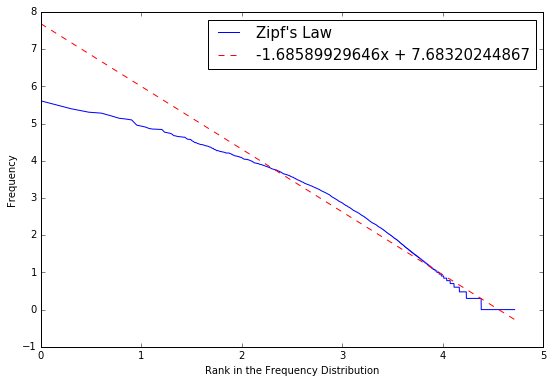

In [80]:
plt.plot(x, y, '-', c='blue', label="Zipf's Law")
plt.plot(x, m*x + b, '--', c='red', label= (str(m) + 'x ' + '+ ' + str(b)))
plt.xlabel('Rank in the Frequency Distribution')
plt.ylabel('Frequency')
plt.legend(loc='best', fontsize=15)

Note that is a log-log scale. So in practice, we find Zipf's to be generally true, given the linear relationship we find between frequency and rank in the log-log scale. However, Zipf's law tend to underestimate the frequency of middle words, given the slight bump we observe in the curve towards the middle.

## 2. Construct a Controlled Vocabulary

Generate all the bigrams and unigrams based on the resulting tokens from the pre-processing step (only in the train folder), and mix those bigrams with the unigrams as our initial controlled vocabulary.

In [87]:
train_reviews = reviews[0:TRAIN_SIZE]

In [90]:
unigram = [[word for word in review if word not in stemmed_stopwords] for review in train_reviews]

In [104]:
# Construct the bigrams and filter out the bigrams that have at least one stopword
bigrams = []
for review in train_reviews:
    review_bigrams = zip(*[review[i:] for i in range(2)])
    bigrams.append(list(filter(lambda bigram: all([word not in stemmed_stopwords for word in bigram]), review_bigrams)))

In [107]:
ngram = []
for uni, bi in zip(unigram, bigrams):
    ngram.append(uni+bi)

Collect the document frequency statistics for all the N-grams (i.e., unigram and bigram) in this initial controlled vocabulary

In [108]:
df = Counter()
for review in ngram:
    for unique_ngrams in set(review):
        df[unique_ngrams] += 1

Find out the top 100 N-grams by document-frequency

In [109]:
df.most_common(100)

[('good', 17744),
 ('NUM', 17025),
 ('food', 16802),
 ('great', 13723),
 ('order', 11913),
 ('time', 11287),
 ('wait', 9866),
 ('servic', 9531),
 ('back', 9361),
 ('friend', 9103),
 ('love', 9061),
 ('fri', 8677),
 ('delici', 7966),
 ('restaur', 7556),
 ('sauc', 7555),
 ('eat', 6986),
 ('dish', 6975),
 ('tabl', 6792),
 ('make', 6540),
 ('menu', 6233),
 ('chees', 6174),
 ('tast', 6084),
 ('amaz', 5899),
 ('chicago', 5884),
 ('thing', 5799),
 ('nice', 5668),
 ('peopl', 5469),
 ('pretti', 5458),
 ('seat', 5432),
 ('night', 5355),
 ('perfect', 5058),
 ('recommend', 4954),
 ('flavor', 4891),
 ('drink', 4886),
 ('bar', 4793),
 ('meal', 4745),
 ('price', 4735),
 ('dinner', 4614),
 ('small', 4544),
 ('$', 4514),
 ('favorit', 4483),
 ('bit', 4460),
 ('worth', 4429),
 (('$', 'NUM'), 4334),
 ('made', 4215),
 ('side', 4144),
 ('enjoy', 4140),
 ('chicken', 4131),
 ('experi', 4102),
 ('long', 4051),
 ('star', 4033),
 ('pizza', 4005),
 ('top', 4000),
 ('fresh', 3977),
 ('line', 3855),
 ('review', 383

Controlled vocabulary size

In [110]:
len(df) - 100

287589

Filter out the most common 50 ngrams

In [111]:
restaurant_stop_ngrams = list(map(lambda x: x[0], df.most_common(50)))

In [112]:
ngram = [[word for word in review if word not in restaurant_stop_ngrams] for review in ngram]

Find the new most common words

In [113]:
df = Counter()
for review in ngram:
    for unique_tokens in set(review):
        df[unique_tokens]+= 1

In [114]:
most_common = df.most_common(50)

Top 50 according to DF in the resulting controlled vocabulary, and their corresponding Inverse Document Frequency

In [116]:
N = len(train)
list(map(lambda word: (word[0], 1 + np.log(N/word[1])), most_common))

[('star', 3.2610189585411513),
 ('pizza', 3.2679858939120594),
 ('top', 3.2692351133124915),
 ('fresh', 3.2750017082068283),
 ('line', 3.3061584674170894),
 ('review', 3.3126646712398276),
 ('serv', 3.3221086029195597),
 ('day', 3.3393893732356985),
 ('lot', 3.3431507962626594),
 ('plate', 3.3463861725009068),
 ('atmospher', 3.3466562602810765),
 ('sweet', 3.3720987487717307),
 ('minut', 3.3945149297392492),
 ('tasti', 3.4110867375527332),
 ('expect', 3.4588834454929072),
 ('staff', 3.4603956187736507),
 ('visit', 3.4689063084415594),
 ('special', 3.474722948138286),
 ('feel', 3.4845965241846462),
 ('lunch', 3.4958220864044613),
 ('awesom', 3.4977053261324262),
 ('reserv', 3.5036924245269749),
 ('french', 3.5062240714487545),
 ('hour', 3.5074923024367495),
 ('salad', 3.5276820604959376),
 ('big', 3.5499415720278473),
 ('excel', 3.5529251644947348),
 ('high', 3.5572505746655101),
 ('end', 3.5582514087774091),
 ('bread', 3.5589191884349458),
 ('disappoint', 3.5649493574615367),
 ('wine',

Least common Ngrams with their corresponding IDF.

In [117]:
least_common = df.most_common()[:-50-1:-1]
list(map(lambda word: (word[0], 1 + np.log(N/word[1])), least_common))

[(('head', 'chee'), 11.56328475341452),
 (('free', 'minti'), 11.56328475341452),
 (('drunken', 'bunch'), 11.56328475341452),
 ('sort-of-tir', 11.56328475341452),
 ('oh-so-right', 11.56328475341452),
 (('waiter', 'emphas'), 11.56328475341452),
 (('mushroom', 'orzo'), 11.56328475341452),
 (('home', 'bbq'), 11.56328475341452),
 (('quick', 'pretti'), 11.56328475341452),
 (('delici', 'crunchy-on-the-outsid'), 11.56328475341452),
 (('magnet', 'fast'), 11.56328475341452),
 (('dryer', 'sonoma'), 11.56328475341452),
 (("s'mac", 'special'), 11.56328475341452),
 (('lip-smack', 'unctious'), 11.56328475341452),
 (('crunchi', 'shrimp'), 11.56328475341452),
 (('eclect', 'feel'), 11.56328475341452),
 (('glaze', 'appl'), 11.56328475341452),
 ('chaackkenn', 11.56328475341452),
 ('denteoctopus', 11.56328475341452),
 (('plump', 'recent'), 11.56328475341452),
 ('money--app', 11.56328475341452),
 (('sushi', 'spici'), 11.56328475341452),
 (('crunch', 'mmm'), 11.56328475341452),
 (('mayo', 'siracha'), 11.5632

## Document Similarity

With the above automatically constructed controlled vocabulary, each review document can be represented as a N-gram vector. Specifically, each dimension in this vector space is defined by the mix of unigrams and bigrams defined in the controlled vocabulary; while the weight for each unigram/bigram in a review document is defined by TF-IDF. Specifically, we will use "Sub-linear TF scaling" to compute the normalized TF of each unigram/bigram in a review document. Note the IDF statistics should be only computed based on the train folder.

In [119]:
# We need to be able to map a list of Ngrams as a list of numbers, so that we can represent a document as a N-gram vector
index_to_vocabulary = df.keys()
vocabulary_to_index = {}
for index, word in enumerate(index_to_vocabulary):
    vocabulary_to_index[word] = index

What is the size of our vocabulary?

In [120]:
vocab_size = len(vocabulary_to_index)
vocab_size

287639

Given the large size of our vocabulary and of our training set, we will use sparse matrix data structures to build Document vectors

In [121]:
def sparse_vectorize_doc(document, vocabulary_to_index):
    '''Build sparse sublinear term frequency vectors from a given document'''
    vocab_size = len(vocabulary_to_index)
    indices = []; data = []
    word_counts = Counter(document)
    for word in word_counts:
        try:
            index = vocabulary_to_index[word]
            indices.append(index)
            # Sub-linear TF weighing
            data.append(1 + np.log(word_counts[word]))
        except:
            pass
    return indices, data

In [122]:
col = []; data = []; row = []
for index, document in enumerate(ngram):
    col_indices, dat = sparse_vectorize_doc(document, vocabulary_to_index)
    col.append(col_indices)
    data.append(dat)
    row.append([index] * len(col_indices))
col = [item for sublist in col for item in sublist]
data = [item for sublist in data for item in sublist]
row = [item for sublist in row for item in sublist]

In [123]:
N = len(ngram)

Build the sparse TF matrix

In [124]:
tf_matrix = sparse.csr_matrix((data, (row, col)), shape=(N, vocab_size))

Now build a IDF vector that is properly ordered

In [125]:
idf = [(vocabulary_to_index[key], 1+np.log(N/df[key])) for key in index_to_vocabulary]
idf = sorted(idf)
idf = np.array(list(map(lambda x: x[1], idf)))

In [126]:
idf_mat = sparse.lil_matrix((vocab_size, vocab_size))
idf_mat.setdiag(idf)

In [127]:
tfidf_matrix = tf_matrix.dot(idf_mat)
tfidf_matrix.shape

(38688, 287639)

Under the folder of "/home/hw5x/TextMining/MP1/data/Yelp", there is a special json file named "query.json", which is manually crafted by the instructor. It contains five carefully selected restaurant reviews from and outside the provided corpus. Construct the vector space representations for these five reviews (as what you have done for those review documents in the test folder) and find out the most similar reviews to them from the test folder, where the similarity metric is defined as cosine similarity.

Load the test data.

In [128]:
test, authors, dates = load_yelp_reviews('../data/yelp/')

Construct the unigram and bigrams

In [137]:
unigram = [[word for word in review if word not in stemmed_stopwords] for review in reviews]

In [138]:
bigrams = []
for review in reviews:
    review_bigrams = zip(*[review[i:] for i in range(2)])
    bigrams.append(list(filter(lambda bigram: any([word not in stemmed_stopwords for word in bigram]), review_bigrams)))

In [139]:
ngram = []
for uni, bi in zip(unigram, bigrams):
    ngram.append(uni+bi)

In [140]:
ngram = [[word for word in review if word not in restaurant_stop_ngrams] for review in ngram]

In [141]:
col = []; data = []; row = []
for index, document in enumerate(ngram):
    col_indices, dat = sparse_vectorize_doc(document, vocabulary_to_index)
    col.append(col_indices)
    data.append(dat)
    row.append([index] * len(col_indices))
col = [item for sublist in col for item in sublist]
data = [item for sublist in data for item in sublist]
row = [item for sublist in row for item in sublist]
tf_test = sparse.csr_matrix((data, (row, col)), shape=(len(ngram), vocab_size))
tfidf_test = tf_test.dot(idf_mat)

In [142]:
def cosine_similarity(v1,v2):
    "compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    v2_T = v2.T
    sumxx = v1.dot(v1.T)[0, 0]
    sumxy = v1.dot(v2_T)[0, 0]
    sumyy = v2.dot(v2_T)[0, 0]
    if sumxx == 0 or sumyy == 0:
        return -1
    else:
        return sumxy/math.sqrt(sumxx*sumyy)

Create a function for finding the three most similar reviews to a to_be_mached Document vector, given a TFIDF document matrix.

In [143]:
def most_similar_reviews(to_be_matched, tfidf_matrix):
    cosines = []
    for index in range(len(train)):
        similarity = cosine_similarity(to_be_matched, tfidf_matrix[index,:])
        cosines.append((similarity, index))
    cosines.sort(reverse=True)
    cosines = cosines[0:3]
    results = [(train_authors[cosine[1]], train_dates[cosine[1]], cosine[0], train[cosine[1]]) for cosine in cosines]
    return results

We run that function on the first document!

In [145]:
print(most_similar_reviews(tfidf_test[0,:], tfidf_matrix))

[('Mary B.', '2013-04-16', 0.23924044451892357, 'Get the bacon wrapped dates! This place is SO good.'), ('Anne K.', '2010-07-25', 0.21187199881122043, 'The food was really good. I like the bacon wrapped dates and the potatoes with paprika'), ('Anamaria H.', '2014-06-27', 0.20180372970372265, "Try the bacon wrapped dates! They're absolutely delicious! You get 8 with an order but you'll wish there were more.")]


The first document is likely a review that mentions bacon-wrapped dates.